<a href="https://colab.research.google.com/github/Burak-Akca/Garbage-Classification_with_Vit/blob/main/garbage_classification_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Rescaling,Dense,RandomTranslation,RandomBrightness,RandomWidth,RandomHeight,RandomContrast, Conv2D,Input, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout,Rescaling,RandomFlip,RandomRotation,RandomZoom,Reshape
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

In [ ]:
zip_ref=zipfile.ZipFile("/content/drive/MyDrive/Data/ysa-data.zip")

In [ ]:
zip_ref.extractall("/content/")

In [ ]:

zip_ref.close()


In [ ]:
data_dir="/content/ysa-data"

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(224, 224),
    batch_size=32
)

Found 9194 files belonging to 10 classes.


In [ ]:
len(dataset)

288

In [ ]:
train_size =0.8
len(dataset)*train_size

230.4

In [ ]:
train_ds=dataset.take(230)
test_ds=dataset.skip(230)

In [ ]:
len(test_ds)

58

In [ ]:
val_size=0.1
len(dataset)*val_size

28.8

In [ ]:
val_ds=test_ds.take(28)
test_ds=test_ds.skip(28)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

# Model ağırlıklarını kaydetmek için
checkpoint = ModelCheckpoint(
    filepath='best_model_efficientnetb7.keras',  # Ağırlıkların kaydedileceği dosya
    monitor='val_accuracy',        # İzlenecek metrik
    save_best_only=True,       # Sadece en iyi model kaydedilir
    mode='max',                # Metrik düşüşüne odaklanır
    verbose=1
)

# Öğrenme oranını dinamik olarak azaltmak için
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',        # İzlenecek metrik
    factor=0.5,
    patience=3,
    min_lr=1e-6,               # Öğrenme oranının minimum değeri
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
data_augmentation = Sequential([
            # Görüntüyü 0-255 aralığından 0-1 aralığına normalize et
    RandomFlip("horizontal"),   # Görüntüyü yatay çevir
    RandomRotation(0.3),        # %30 oranında rastgele döndür
    RandomZoom(0.2),            # %20 oranında rastgele zoom
    RandomContrast(0.2),        # Kontrastı rastgele değiştir (%20)
    RandomHeight(0.2),          # Görüntü yüksekliğini rastgele değiştir
    RandomWidth(0.2),           # Görüntü genişliğini rastgele değiştir
])

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random

# Özelleştirilmiş Dataset Sınıfı
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Verilerin bulunduğu ana klasör.
            transform (callable, optional): Verilere uygulanacak dönüşüm (transform).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)  # Klasörlerin isimleri, her bir sınıfı temsil eder.
        self.image_paths = []
        self.labels = []

        # Her bir sınıf için resim dosyalarını topla
        for label, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for image_name in os.listdir(class_folder):
                    if image_name.endswith(('jpg', 'jpeg', 'png')):
                        self.image_paths.append(os.path.join(class_folder, image_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Görüntü dosyasını aç
        label = self.labels[idx]  # Etiket (sınıf) bilgisini al

        # Dönüşümleri uygula (varsa)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:


# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resimleri boyutlandır
    transforms.ToTensor(),  # Tensor'a dönüştür
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizasyon
])

# Veri setini yükle
root_dir = '/content/ysa-data'  # Kendi veri setinizin yolu
dataset = CustomDataset(root_dir=root_dir, transform=transform)

# Veri setini karıştır (shuffle) ve böl
train_size = int(0.7 * len(dataset))  # Eğitim verisi %70
val_size = int(0.15 * len(dataset))   # Doğrulama verisi %15
test_size = len(dataset) - train_size - val_size  # Test verisi %15

# Veri setini 3'e ayır
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader'lar
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Modeli yükleyin (Örnek: ViT)
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10)

# Modeli GPU'ya taşı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Kayıp fonksiyonu ve optimizasyon
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Modeli Eğitme
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Gradients sıfırlanır

        outputs = model(images).logits  # Modelden çıktılar alınır
        loss = criterion(outputs, labels)  # Kayıp hesaplanır

        loss.backward()  # Geriye doğru geçiş yapılır
        optimizer.step()  # Parametre güncellenir

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Etiket tahmini
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")

    # Doğrulama seti üzerinde modelin performansını değerlendirme
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Test Seti ile Modeli Değerlendirme
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Training Loss: 0.7577, Training Accuracy: 85.92%
Epoch 1/10, Validation Loss: 0.3262, Validation Accuracy: 93.33%
Epoch 2/10, Training Loss: 0.1733, Training Accuracy: 96.67%
Epoch 2/10, Validation Loss: 0.2273, Validation Accuracy: 94.78%
Epoch 3/10, Training Loss: 0.0828, Training Accuracy: 98.41%
Epoch 3/10, Validation Loss: 0.1863, Validation Accuracy: 95.21%
Epoch 4/10, Training Loss: 0.0545, Training Accuracy: 98.97%
Epoch 4/10, Validation Loss: 0.2393, Validation Accuracy: 94.05%
Epoch 5/10, Training Loss: 0.0559, Training Accuracy: 98.62%
Epoch 5/10, Validation Loss: 0.1800, Validation Accuracy: 95.29%
Epoch 6/10, Training Loss: 0.0499, Training Accuracy: 98.79%
Epoch 6/10, Validation Loss: 0.1744, Validation Accuracy: 95.72%
Epoch 7/10, Training Loss: 0.0393, Training Accuracy: 99.02%
Epoch 7/10, Validation Loss: 0.1925, Validation Accuracy: 95.50%
Epoch 8/10, Training Loss: 0.0197, Training Accuracy: 99.55%
Epoch 8/10, Validation Loss: 0.2002, Validation Accuracy:

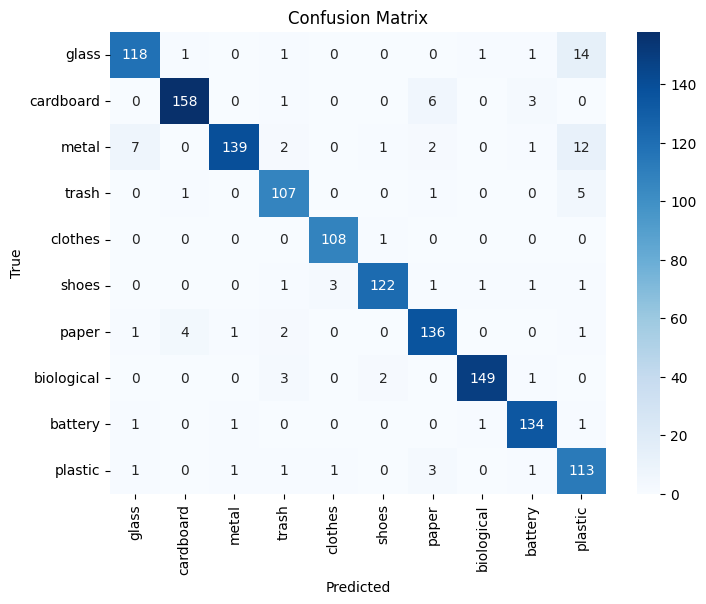

Classification Report:
               precision    recall  f1-score   support

       glass       0.92      0.87      0.89       136
   cardboard       0.96      0.94      0.95       168
       metal       0.98      0.85      0.91       164
       trash       0.91      0.94      0.92       114
     clothes       0.96      0.99      0.98       109
       shoes       0.97      0.94      0.95       130
       paper       0.91      0.94      0.93       145
  biological       0.98      0.96      0.97       155
     battery       0.94      0.97      0.96       138
     plastic       0.77      0.93      0.84       121

    accuracy                           0.93      1380
   macro avg       0.93      0.93      0.93      1380
weighted avg       0.93      0.93      0.93      1380



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test Seti ile Modeli Değerlendirme
model.eval()
all_preds = []
all_labels = []

# Test verisinde tahminler
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", report)

In [ ]:
# Modeli yükle (Örnek: Swin Transformer)
from transformers import SwinForImageClassification

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=10,  # Sınıf sayısı
    ignore_mismatched_sizes=True  # Boyut uyuşmazlıklarını göz ardı et
)

# Modeli GPU'ya taşı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Kayıp fonksiyonu ve optimizasyon
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Modeli Eğitme
num_epochs = 10
best_val_acc = 0.0  # En iyi doğrulama doğruluğunu takip etmek için
best_model_path = "best_model.pth"  # Modelin kaydedileceği dosya yolu

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Gradients sıfırlanır

        outputs = model(images).logits  # Modelden çıktılar alınır
        loss = criterion(outputs, labels)  # Kayıp hesaplanır

        loss.backward()  # Geriye doğru geçiş yapılır
        optimizer.step()  # Parametre güncellenir

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)  # Etiket tahmini
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")

    # Doğrulama seti üzerinde modelin performansını değerlendirme
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # En iyi doğrulama doğruluğunu kontrol et ve modeli kaydet
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with Validation Accuracy: {val_acc:.2f}%")

# Test Seti ile Modeli Değerlendirme
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([10, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Training Loss: 0.2813, Training Accuracy: 91.20%
Epoch 1/10, Validation Loss: 0.1696, Validation Accuracy: 95.43%
Best model saved at epoch 1 with Validation Accuracy: 95.43%
Epoch 2/10, Training Loss: 0.0744, Training Accuracy: 97.72%
Epoch 2/10, Validation Loss: 0.1215, Validation Accuracy: 96.52%
Best model saved at epoch 2 with Validation Accuracy: 96.52%
Epoch 3/10, Training Loss: 0.0459, Training Accuracy: 98.65%
Epoch 3/10, Validation Loss: 0.1615, Validation Accuracy: 95.21%
Epoch 4/10, Training Loss: 0.0409, Training Accuracy: 98.77%
Epoch 4/10, Validation Loss: 0.1920, Validation Accuracy: 95.29%
Epoch 5/10, Training Loss: 0.0381, Training Accuracy: 98.99%
Epoch 5/10, Validation Loss: 0.1489, Validation Accuracy: 96.23%
Epoch 6/10, Training Loss: 0.0343, Training Accuracy: 99.04%
Epoch 6/10, Validation Loss: 0.1880, Validation Accuracy: 95.00%
Epoch 7/10, Training Loss: 0.0377, Training Accuracy: 98.96%
Epoch 7/10, Validation Loss: 0.1586, Validation Accuracy: 96.

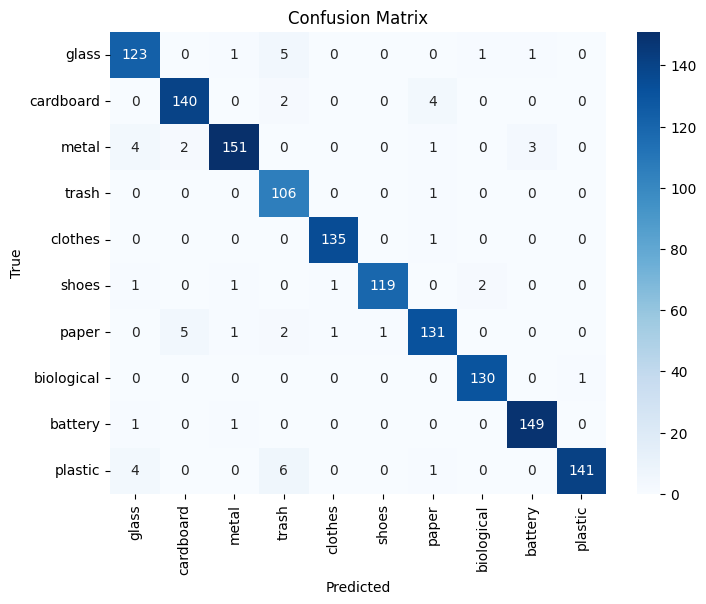

Classification Report:
               precision    recall  f1-score   support

       glass       0.92      0.94      0.93       131
   cardboard       0.95      0.96      0.96       146
       metal       0.97      0.94      0.96       161
       trash       0.88      0.99      0.93       107
     clothes       0.99      0.99      0.99       136
       shoes       0.99      0.96      0.98       124
       paper       0.94      0.93      0.94       141
  biological       0.98      0.99      0.98       131
     battery       0.97      0.99      0.98       151
     plastic       0.99      0.93      0.96       152

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Test Seti ile Modeli Değerlendirme
model.eval()
all_preds = []
all_labels = []

# Test verisinde tahminler
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report (Precision, Recall, F1-Score)
report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report:\n", report)